In [2]:
import torch
import numpy as np
import plotly.graph_objects as go
from collections import defaultdict
import torch.nn.functional as F
import json
import os
from typing import Dict, List, Tuple
from transformers import AutoModelForCausalLM, AutoTokenizer

In [3]:
def get_device():
    """Get the optimal available device"""
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        # Enable TF32 for better performance on Ampere GPUs (A100, A6000, etc)
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        # Set memory allocation settings
        torch.cuda.empty_cache()
        # Enable CUDNN benchmarking for better performance
        torch.backends.cudnn.benchmark = True
    else:
        device = torch.device("cpu")
    return device

In [ ]:
model = AutoModelForCausalLM.from_pretrained("deepseek-ai/deepseek-moe-16b-base", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-moe-16b-base", trust_remote_code=True)
model.eval()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

DeepseekForCausalLM(
  (model): DeepseekModel(
    (embed_tokens): Embedding(102400, 2048)
    (layers): ModuleList(
      (0): DeepseekDecoderLayer(
        (self_attn): DeepseekSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): DeepseekRotaryEmbedding()
        )
        (mlp): DeepseekMLP(
          (gate_proj): Linear(in_features=2048, out_features=10944, bias=False)
          (up_proj): Linear(in_features=2048, out_features=10944, bias=False)
          (down_proj): Linear(in_features=10944, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): DeepseekRMSNorm()
        (post_attention_layernorm): DeepseekRMSNorm()
      )
      (1-27): 27 x DeepseekDecod

In [27]:
class MOEExpertLens:
    def __init__(self, state_dict: Dict[str, torch.Tensor], tokenizer, device=None):
        """Initialize the MoE Expert analyzer."""
        self.device = device if device is not None else get_device()
        self.state_dict = {k: v.to(self.device) for k, v in state_dict.items()}
        self.tokenizer = tokenizer
        self.hidden_size = self.state_dict["model.embed_tokens.weight"].shape[1]
        self.vocab_size = self.state_dict["model.embed_tokens.weight"].shape[0]

    def _process_expert(self, layer_idx: int, expert_idx: int, hidden_state: torch.Tensor) -> torch.Tensor:
        """Process hidden state through an expert's weights."""
        # Get expert weights
        gate_proj = self.state_dict[f"model.layers.{layer_idx}.mlp.experts.{expert_idx}.gate_proj.weight"]
        up_proj = self.state_dict[f"model.layers.{layer_idx}.mlp.experts.{expert_idx}.up_proj.weight"]
        down_proj = self.state_dict[f"model.layers.{layer_idx}.mlp.experts.{expert_idx}.down_proj.weight"]

        # Apply MLPs sequentially
        # First gate projection and activation
        gate_output = F.silu(F.linear(hidden_state, gate_proj))
        
        # Second up projection and activation 
        up_output = F.silu(F.linear(hidden_state, up_proj))
        
        # Multiply gate and up projections then down project
        x = gate_output * up_output
        x = F.linear(x, down_proj)
        return x

    def _get_router_output(self, layer_idx: int, hidden_state: torch.Tensor) -> torch.Tensor:
        """Get router logits for a layer."""
        router_weights = self.state_dict[f"model.layers.{layer_idx}.mlp.gate.weight"]
        return F.linear(hidden_state, router_weights)

    def _process_attention(self, layer_idx: int, hidden_state: torch.Tensor) -> torch.Tensor:
        """Process hidden state through self-attention."""
        q_proj = self.state_dict[f"model.layers.{layer_idx}.self_attn.q_proj.weight"]
        k_proj = self.state_dict[f"model.layers.{layer_idx}.self_attn.k_proj.weight"]
        v_proj = self.state_dict[f"model.layers.{layer_idx}.self_attn.v_proj.weight"]
        o_proj = self.state_dict[f"model.layers.{layer_idx}.self_attn.o_proj.weight"]

        # Compute QKV
        q = F.linear(hidden_state, q_proj)
        k = F.linear(hidden_state, k_proj)
        v = F.linear(hidden_state, v_proj)

        # Compute attention and output projection
        attn = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.hidden_size)
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, v)
        return F.linear(out, o_proj)

    def _project_to_vocab(self, hidden_state: torch.Tensor) -> torch.Tensor:
        """Project hidden state to vocabulary space."""
        # Ensure hidden state has the right shape for projection
        if hidden_state.dim() == 3:
            # If [batch, seq_len, hidden_dim], keep as is
            pass
        elif hidden_state.dim() == 2:
            # If [batch, hidden_dim], add sequence dimension
            hidden_state = hidden_state.unsqueeze(1)
        
        # Get lm_head weights instead of embedding weights for projection
        lm_head_weights = self.state_dict["lm_head.weight"]
        
        # Project to vocab space: [batch, seq_len, hidden_dim] x [vocab_size, hidden_dim]^T
        return F.linear(hidden_state, lm_head_weights)

    def analyze_text(self, input_ids: torch.Tensor) -> Dict:
        """Analyze text through expert lens."""
        batch_size, seq_len = input_ids.shape
        hidden_states = self.state_dict["model.embed_tokens.weight"][input_ids]
        
        results = {}
        
        for layer_idx in range(1, 28):  # Layers 1-27
            # Apply layer normalization
            if f"model.layers.{layer_idx}.input_layernorm.weight" in self.state_dict:
                norm_weight = self.state_dict[f"model.layers.{layer_idx}.input_layernorm.weight"]
                hidden_states = F.layer_norm(hidden_states, (self.hidden_size,), weight=norm_weight)
            
            layer_results = {"tokens": {}}
            
            # Process attention
            hidden_states = self._process_attention(layer_idx, hidden_states)
            
            # Post-attention layer norm
            if f"model.layers.{layer_idx}.post_attention_layernorm.weight" in self.state_dict:
                norm_weight = self.state_dict[f"model.layers.{layer_idx}.post_attention_layernorm.weight"]
                hidden_states = F.layer_norm(hidden_states, (self.hidden_size,), weight=norm_weight)
            
            # Get router decisions
            router_logits = self._get_router_output(layer_idx, hidden_states)
            top_k_experts = torch.topk(router_logits, k=7, dim=-1)
            expert_weights = F.softmax(top_k_experts.values, dim=-1)
            
            # Process through selected experts
            for pos in range(seq_len):
                token = self.tokenizer.decode([input_ids[0, pos].item()])
                token_state = hidden_states[:, pos:pos+1]
                
                expert_outputs = []
                for idx, expert_idx in enumerate(top_k_experts.indices[0, pos]):
                    expert_output = self._process_expert(layer_idx, expert_idx.item(), token_state)
                    weight = expert_weights[0, pos, idx].item()
                    
                    # Project expert output to vocab space
                    logits = self._project_to_vocab(expert_output)
                    top_tokens = torch.topk(logits.squeeze(1), k=5)
                    
                    expert_outputs.append({
                        "expert_id": expert_idx.item(),
                        "weight": weight,
                        "top_tokens": [
                            (self.tokenizer.decode([idx.item()]), prob.item())
                            for idx, prob in zip(top_tokens.indices[0], F.softmax(top_tokens.values[0], dim=-1))
                        ]
                    })
                
                layer_results["tokens"][token] = {
                    "position": pos,
                    "expert_outputs": expert_outputs
                }
            
            results[f"layer_{layer_idx}"] = layer_results
            
        return results

def visualize_layer_analysis(results: Dict, layer_idx: int, token_position: int):
    """Visualize expert interpretations for a specific layer and token."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    layer_data = results[f"layer_{layer_idx}"]
    token_data = [data for data in layer_data["tokens"].values() 
                 if data["position"] == token_position][0]
    
    plt.figure(figsize=(15, 10))
    expert_outputs = token_data["expert_outputs"]
    
    for idx, expert_data in enumerate(expert_outputs):
        tokens, probs = zip(*expert_data["top_tokens"])
        
        plt.subplot(len(expert_outputs), 1, idx + 1)
        sns.barplot(x=list(tokens), y=list(probs))
        plt.title(f"Expert {expert_data['expert_id']} (Weight: {expert_data['weight']:.3f})")
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [28]:
def apply_moe_logit_lens_with_active_expert_outputs(model, inputs, tokenizer, num_active_experts=7):
    model.eval()

    # Initial embedding
    x = model.model.embed_tokens(inputs)

    # Process each layer
    for layer_idx, layer in enumerate(model.model.layers):
        print(f"Layer {layer_idx + 1}")
        x = layer.input_layernorm(x)

        # Self-attention output
        # Remove the position_ids argument here, let the model handle it internally
        attn_output = layer.self_attn(x, x, x)
        x = attn_output + x  # Residual connection
        x = layer.post_attention_layernorm(x)

        # MoE Layer
        moe_output = layer.mlp(x)
        gate_values = moe_output["gate_values"]
        expert_outputs = moe_output["expert_outputs"]

        # Extract active experts
        for batch_idx, gates in enumerate(gate_values):
            active_experts = gates.argsort(descending=True)[:num_active_experts]
            print(f"  Batch {batch_idx + 1}:")
            for expert_idx in active_experts:
                expert_weight = gates[expert_idx].item()
                expert_output = expert_outputs[batch_idx, :, expert_idx]
                top_tokens = expert_output.topk(5, dim=-1)
                top_indices = top_tokens.indices
                top_scores = top_tokens.values
                decoded_tokens = tokenizer.decode(top_indices.tolist())
                print(f"    Expert {expert_idx}: Weight: {expert_weight:.4f}, Tokens: {decoded_tokens}, Scores: {top_scores.tolist()}")

    # Final logits
    logits = model.lm_head(x)
    top_tokens = logits.topk(5, dim=-1)
    decoded_final_tokens = tokenizer.decode(top_tokens.indices.tolist())
    print(f"Final Layer: Tokens: {decoded_final_tokens}, Scores: {top_tokens.values.tolist()}")

In [29]:
def get_device():
    """Get the optimal available device"""
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        # Enable TF32 for better performance on Ampere GPUs (A100, A6000, etc)
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        # Set memory allocation settings
        torch.cuda.empty_cache()
        # Enable CUDNN benchmarking for better performance
        torch.backends.cudnn.benchmark = True
    else:
        device = torch.device("cpu")
    return device

In [30]:
def apply_moe_logit_lens_with_active_expert_outputs(model, inputs, tokenizer, num_active_experts=7):
    model.eval()

    # Initial embedding
    x = model.model.embed_tokens(inputs)

    # Process each layer
    for layer_idx, layer in enumerate(model.model.layers):
        print(f"Layer {layer_idx + 1}")
        x = layer.input_layernorm(x)

        # Self-attention output
        # Remove the position_ids argument here, let the model handle it internally
        attn_output = layer.self_attn(x, x, x)
        x = attn_output + x  # Residual connection
        x = layer.post_attention_layernorm(x)

        # MoE Layer
        moe_output = layer.mlp(x)
        gate_values = moe_output["gate_values"]
        expert_outputs = moe_output["expert_outputs"]

        # Extract active experts
        for batch_idx, gates in enumerate(gate_values):
            active_experts = gates.argsort(descending=True)[:num_active_experts]
            print(f"  Batch {batch_idx + 1}:")
            for expert_idx in active_experts:
                expert_weight = gates[expert_idx].item()
                expert_output = expert_outputs[batch_idx, :, expert_idx]
                top_tokens = expert_output.topk(5, dim=-1)
                top_indices = top_tokens.indices
                top_scores = top_tokens.values
                decoded_tokens = tokenizer.decode(top_indices.tolist())
                print(f"    Expert {expert_idx}: Weight: {expert_weight:.4f}, Tokens: {decoded_tokens}, Scores: {top_scores.tolist()}")

    # Final logits
    logits = model.lm_head(x)
    top_tokens = logits.topk(5, dim=-1)
    decoded_final_tokens = tokenizer.decode(top_tokens.indices.tolist())
    print(f"Final Layer: Tokens: {decoded_final_tokens}, Scores: {top_tokens.values.tolist()}")

In [31]:
def logit_lens(model, input_tokens):
    """
    Applies a logit lens to each layer of a mixture of experts (MoE) model for specific input tokens.

    Args:
        model (torch.nn.Module): The MoE model.
        input_tokens (torch.Tensor): Input tensor with token embeddings, shape [batch_size, seq_len].

    Returns:
        dict: A dictionary containing the logit lens outputs for each token at each layer.
    """
    logit_outputs = {}

    # Pass the input tokens through the embedding layer
    embedding_output = model.embed_tokens(input_tokens)  # Shape: [batch_size, seq_len, embedding_dim]

    # Process tokens through each layer
    for layer_idx, layer in enumerate(model.layers):
        # Apply the layer and get its output
        layer_outputs = layer(embedding_output)  # Shape: [batch_size, seq_len, feature_dim]

        # Extract the mixture of experts (MoE) components for this layer
        if hasattr(layer.mlp, "experts"):
            gate_outputs = layer.mlp.gate(embedding_output)  # Shape: [batch_size, seq_len, num_experts]
            expert_outputs = []

            # Process each token separately to extract expert-specific outputs
            for token_idx in range(input_tokens.shape[1]):
                token_expert_outputs = []

                for expert_idx, expert in enumerate(layer.mlp.experts):
                    token_input = embedding_output[:, token_idx, :]  # Shape: [batch_size, embedding_dim]
                    expert_output = expert(token_input)  # Shape: [batch_size, feature_dim]
                    token_expert_outputs.append(expert_output)

                # Stack expert outputs and apply gating
                token_expert_outputs = torch.stack(token_expert_outputs, dim=1)  # Shape: [batch_size, num_experts, feature_dim]
                token_gate_weights = gate_outputs[:, token_idx, :].unsqueeze(-1)  # Shape: [batch_size, num_experts, 1]
                activated_experts_output = torch.sum(token_expert_outputs * token_gate_weights, dim=1)  # Shape: [batch_size, feature_dim]

                # Save activated expert outputs for this token
                logit_outputs[f"layer_{layer_idx}_token_{token_idx}_activated_experts"] = activated_experts_output

        # Update the embedding for the next layer
        embedding_output = layer_outputs

    return logit_outputs

/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 25317 (\N{CJK UNIFIED IDEOGRAPH-62E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 20026 (\N{CJK UNIFIED IDEOGRAPH-4E3A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 37009 (\N{CJK UNIFIED IDEOGRAPH-9091}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 20415 (\N{CJK UNIFIED IDEOGRAPH-4FBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk

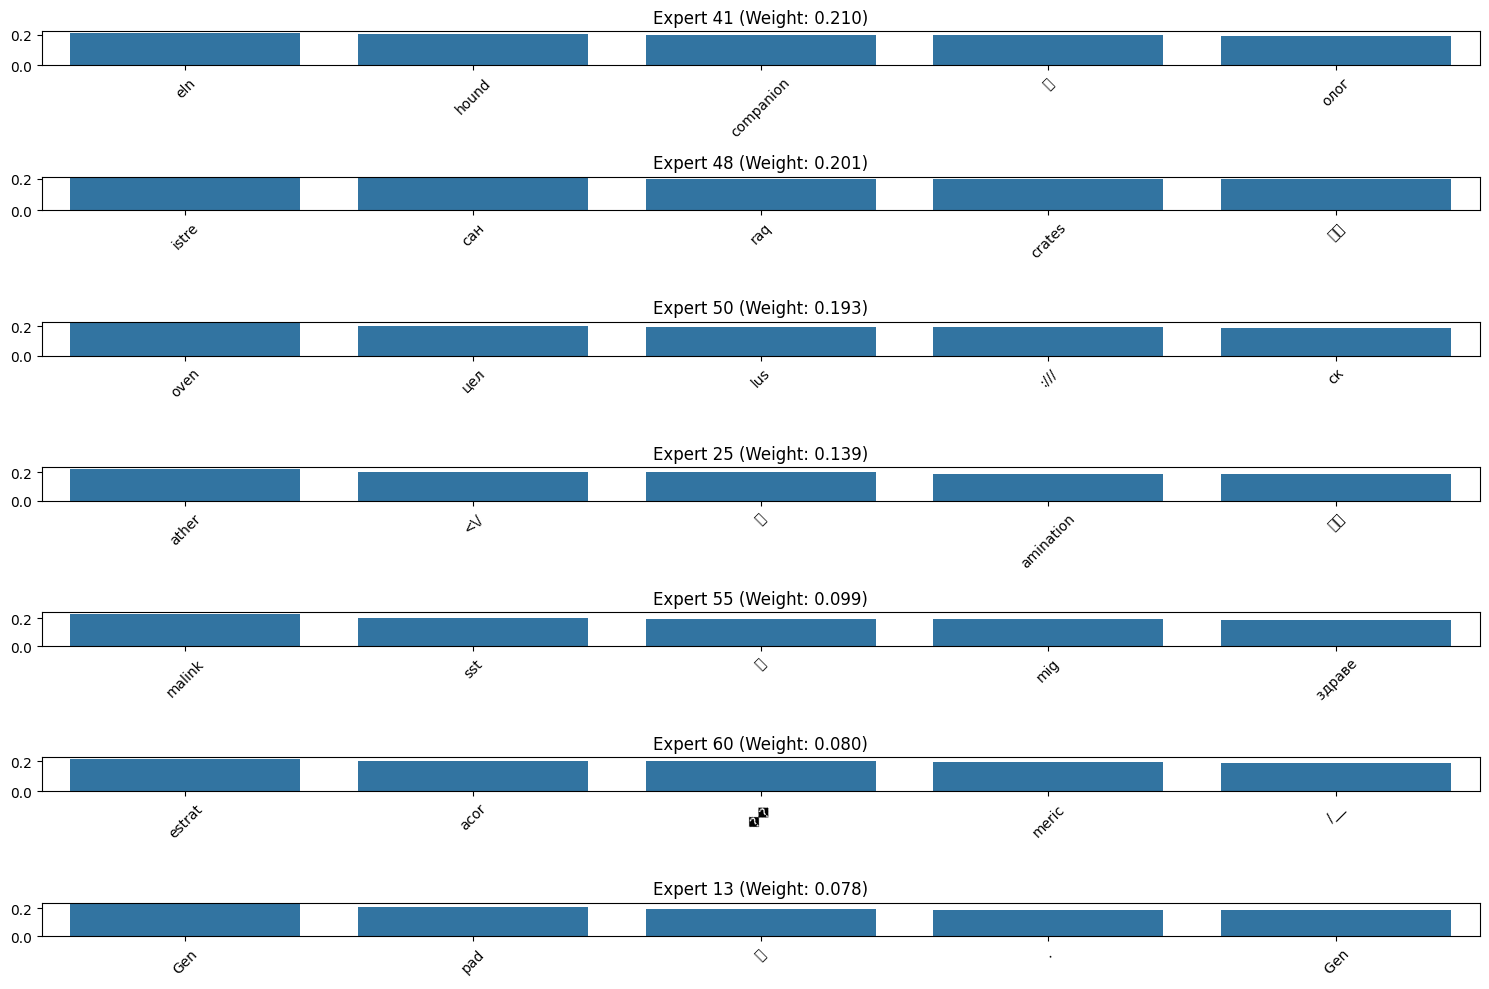

In [32]:
state_dict = model.state_dict()

# Initialize analyzer
analyzer = MOEExpertLens(state_dict, tokenizer)

# Analyze text
text = "The quick brown fox"
input_ids = tokenizer(text, return_tensors="pt").input_ids.to(get_device())
results = analyzer.analyze_text(input_ids)

# Visualize specific layer/token
visualize_layer_analysis(results, layer_idx=4, token_position=1)

/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 20813 (\N{CJK UNIFIED IDEOGRAPH-514D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 36153 (\N{CJK UNIFIED IDEOGRAPH-8D39}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 21672 (\N{CJK UNIFIED IDEOGRAPH-54A8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 35810 (\N{CJK UNIFIED IDEOGRAPH-8BE2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk

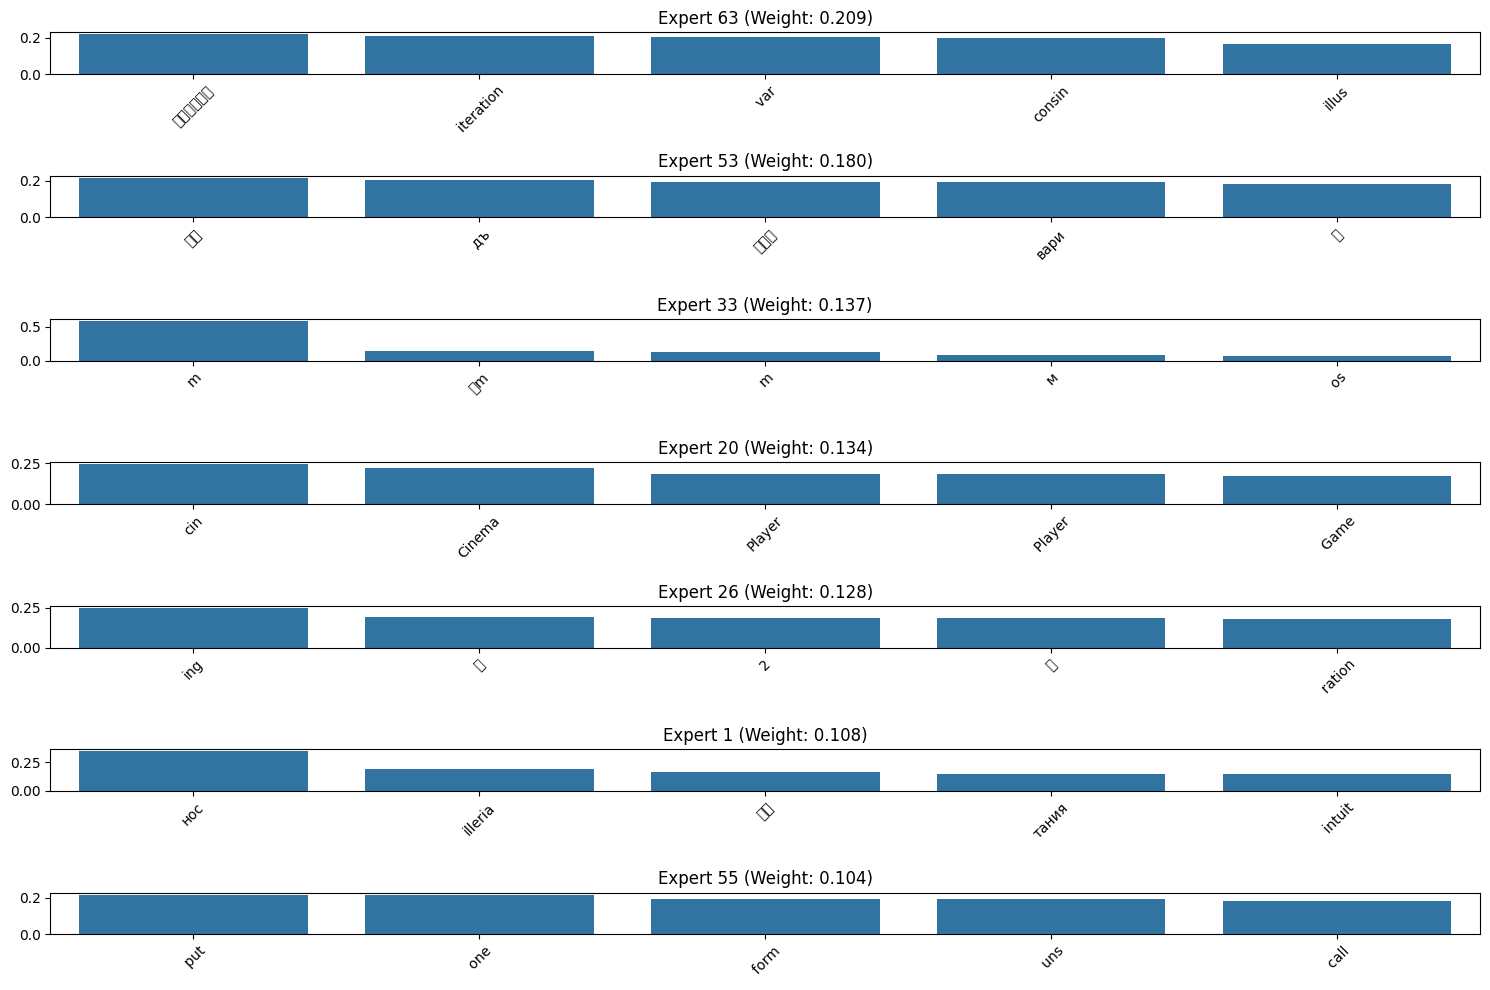

In [36]:
visualize_layer_analysis(results, layer_idx=27, token_position=3)

/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 25317 (\N{CJK UNIFIED IDEOGRAPH-62E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 20026 (\N{CJK UNIFIED IDEOGRAPH-4E3A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 37009 (\N{CJK UNIFIED IDEOGRAPH-9091}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk/sgrd2bsj1msgt6bs3kfgj9hw0000gn/T/ipykernel_13020/2901523061.py:148: UserWarning: Glyph 20415 (\N{CJK UNIFIED IDEOGRAPH-4FBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wk

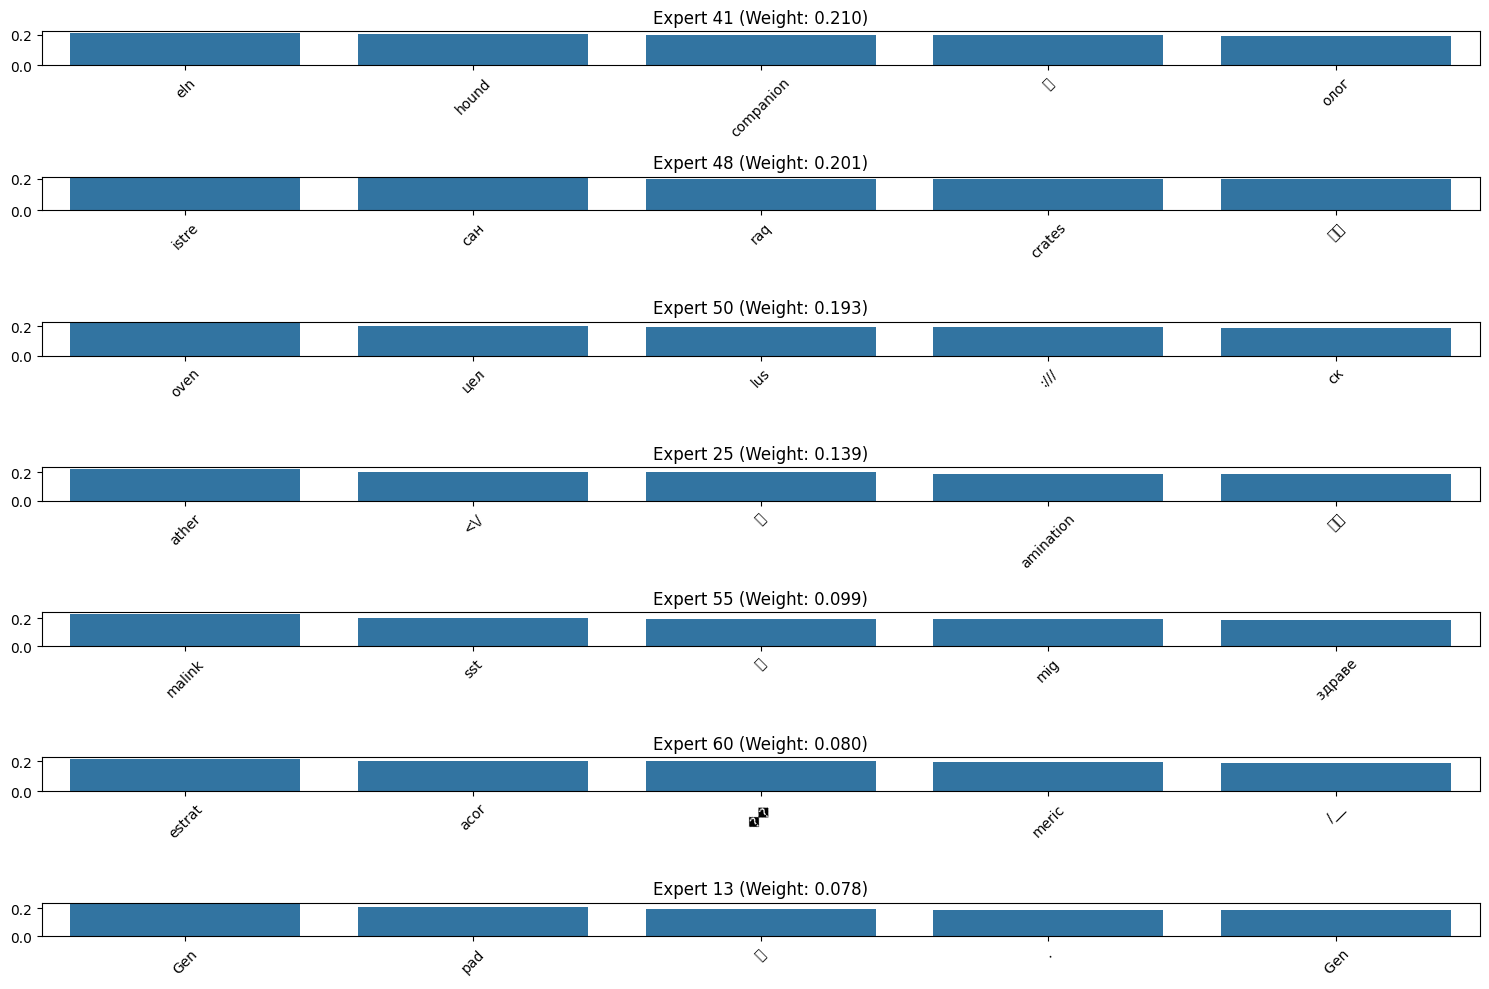

In [34]:
visualize_layer_analysis(results, layer_idx=4, token_position=1)

In [35]:
model.model.layers

ModuleList(
  (0): DeepseekDecoderLayer(
    (self_attn): DeepseekSdpaAttention(
      (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (rotary_emb): DeepseekRotaryEmbedding()
    )
    (mlp): DeepseekMLP(
      (gate_proj): Linear(in_features=2048, out_features=10944, bias=False)
      (up_proj): Linear(in_features=2048, out_features=10944, bias=False)
      (down_proj): Linear(in_features=10944, out_features=2048, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): DeepseekRMSNorm()
    (post_attention_layernorm): DeepseekRMSNorm()
  )
  (1-27): 27 x DeepseekDecoderLayer(
    (self_attn): DeepseekSdpaAttention(
      (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (k_proj): Linear(in_features=2048, out_features=20